# Import

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from IPython.display import clear_output

from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score

from tqdm import tqdm

NUM_CLASSES = 30

RANDOM_SEED = 2
PATH_TO_DATA = '../input/vk-made-sports-image-classification'
PATH_TO_TRAIN_CSV = PATH_TO_DATA + '/train.csv'
PATH_TO_TEST_CSV = PATH_TO_DATA + '/test.csv'
PATH_TO_TRAIN_IMAGES = PATH_TO_DATA + '/train'
PATH_TO_TEST_IMAGES = PATH_TO_DATA + '/test'

IMAGE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
train_data = pd.read_csv(PATH_TO_TRAIN_CSV)

label2id = {}
id2label = {}
for i, label in enumerate(train_data.label.unique(), start=0):
    label2id[label] = i
    id2label[i] = label
label2id

{'swimming': 0,
 'greco-Roman_wrestling': 1,
 'running': 2,
 'football': 3,
 'sailing': 4,
 'basketball': 5,
 'fencing': 6,
 'surfing': 7,
 'alpinism': 8,
 'golf': 9,
 'water_polo': 10,
 'rugby': 11,
 'horseback_riding': 12,
 'sambo': 13,
 'hockey': 14,
 'taekwondo': 15,
 'skating': 16,
 'boating': 17,
 'ski_race': 18,
 'tennis': 19,
 'velo': 20,
 'handball': 21,
 'arm_wrestling': 22,
 'archery': 23,
 'pole_vault': 24,
 'boxing': 25,
 'volleyball': 26,
 'gymnastics': 27,
 'javelin-throwing': 28,
 'badminton': 29}

# Load data

In [4]:
# для работы с датасетом
class ImageDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None, target_transform=None, test=False):
        self.img_dir = img_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.test = test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = label2id[self.data.iloc[idx, 1]] if not self.test else self.data.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label
    
# Вывод изображений
def show_images(dataset, n_images, test=False):
    np.random.seed(RANDOM_SEED)
    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(15, 5))

    for i in range(n_images):
        idx = np.random.randint(0, len(dataset))
        image, label_id = dataset[idx]
        class_name = id2label[label_id] if not test else label_id
        image_size = tuple(image.shape[1:])
        axes[i].imshow(image.permute(1, 2, 0), vmin=0, vmax=1)
        axes[i].set_title(f"Class: {class_name}\nSize: {image_size}")
        axes[i].axis('off')

    plt.show()

### Посмотрим на изображения и аугментации

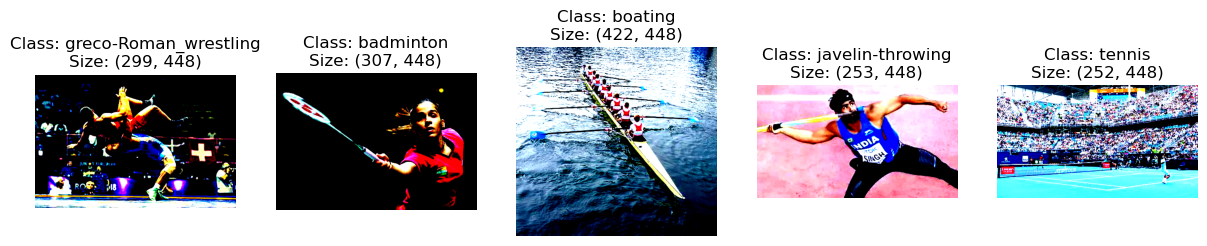

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN,std=STD)
])

train_dataset = ImageDataset(PATH_TO_TRAIN_IMAGES, PATH_TO_TRAIN_CSV, transform=transform)
show_images(train_dataset, 5)

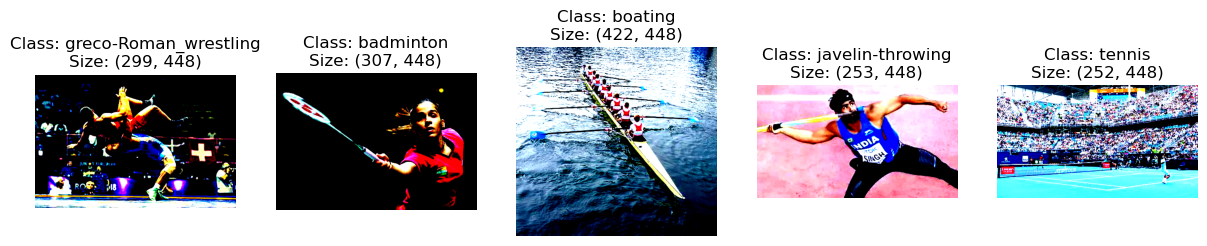

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.Resize(IMAGE_SIZE + 30), # Рессайзим до большего размера чем нужно, чтобы поубирать черные места после поворота
    transforms.CenterCrop(IMAGE_SIZE), # Берем квадрат из центра
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3)
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN,std=STD)
])

all_train_dataset = ImageDataset(PATH_TO_TRAIN_IMAGES, PATH_TO_TRAIN_CSV, transform=train_transforms)
show_images(train_dataset, 5)

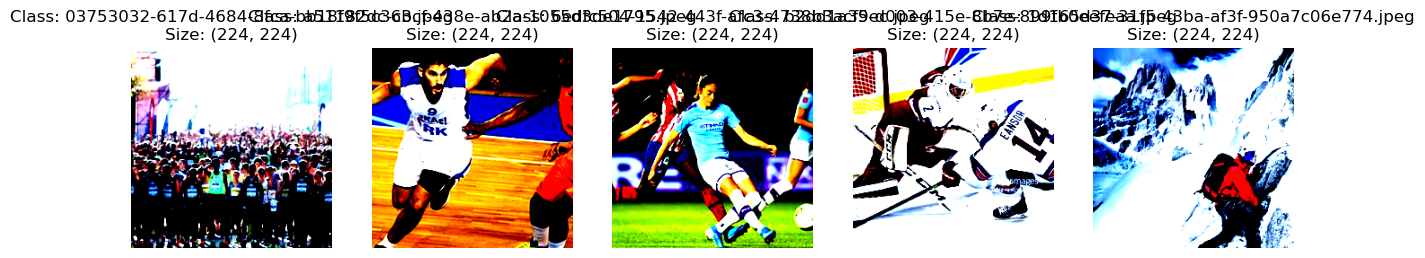

In [7]:
test_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE + 30),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN,std=STD)
])

test_dataset = ImageDataset(PATH_TO_TEST_IMAGES, PATH_TO_TEST_CSV, transform=test_transforms, test=True)
show_images(test_dataset, 5, test=True)

In [8]:
len(train_dataset)

45373

In [9]:
len(test_dataset)

19446

In [10]:
BATCH_SIZE = 512

# Разделение датасета на train и val
train_size = int(0.8 * len(all_train_dataset))
val_size = len(all_train_dataset) - train_size
train_dataset, val_dataset = random_split(all_train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(RANDOM_SEED))

# Создание train и val DataLoader
all_train_loader = DataLoader(all_train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Fine tuning

In [11]:
# функция для обучения модели
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_micro_f1 = 0.0
    tqdm_loader = tqdm(enumerate(loader, 0), total=len(loader))
    for i, data in tqdm_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        running_loss += batch_loss
        preds = torch.argmax(outputs, axis=1)
        batch_f1 = f1_score(labels.cpu(), preds.cpu(), average='micro')
        running_micro_f1 += batch_f1
        tqdm_loader.set_description(f"loss: {batch_loss:.3f}, F1: {batch_f1:.3f}")

    num_batches = len(loader)
    epoch_loss = running_loss / num_batches
    epoch_micro_f1 = running_micro_f1 / num_batches
    return epoch_loss, epoch_micro_f1

# функция для валидации модели
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_micro_f1 = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader, 0), total=len(loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = torch.argmax(outputs, axis=1)
            running_micro_f1 += f1_score(labels.cpu(), preds.cpu(), average='micro')

    num_batches = len(loader)
    epoch_loss = running_loss / num_batches
    epoch_micro_f1 = running_micro_f1 / num_batches
    return epoch_loss, epoch_micro_f1


In [12]:
NUM_EPOCHS = 30

model_ef4 = models.efficientnet_v2_m(pretrained=True)


# Замораживаем все слои кроме последнего полносвязного
for name, param in model_ef4.named_parameters():
    if name.startswith('features.7') or name.startswith('features.8'):
#         f1, f2 = int(name.split('.')[1]), int(name.split('.')[2]) 
#         if f1 == 6 and f2 < 10:
#             param.requires_grad = False
#             continue
        param.requires_grad = True
    else:
        param.requires_grad = False
    print(name, param.requires_grad)

num_params = sum(p.numel() for p in model_ef4.parameters())
print(f"Number of parameters: {num_params}")

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth


  0%|          | 0.00/208M [00:00<?, ?B/s]

features.0.0.weight False
features.0.1.weight False
features.0.1.bias False
features.1.0.block.0.0.weight False
features.1.0.block.0.1.weight False
features.1.0.block.0.1.bias False
features.1.1.block.0.0.weight False
features.1.1.block.0.1.weight False
features.1.1.block.0.1.bias False
features.1.2.block.0.0.weight False
features.1.2.block.0.1.weight False
features.1.2.block.0.1.bias False
features.2.0.block.0.0.weight False
features.2.0.block.0.1.weight False
features.2.0.block.0.1.bias False
features.2.0.block.1.0.weight False
features.2.0.block.1.1.weight False
features.2.0.block.1.1.bias False
features.2.1.block.0.0.weight False
features.2.1.block.0.1.weight False
features.2.1.block.0.1.bias False
features.2.1.block.1.0.weight False
features.2.1.block.1.1.weight False
features.2.1.block.1.1.bias False
features.2.2.block.0.0.weight False
features.2.2.block.0.1.weight False
features.2.2.block.0.1.bias False
features.2.2.block.1.0.weight False
features.2.2.block.1.1.weight False
feat

In [13]:
in_features = model_ef4.classifier[-1].in_features
model_ef4.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, NUM_CLASSES),
)

print(model_ef4.classifier)

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=1280, out_features=30, bias=True)
)


In [14]:
# model_ef4.load_state_dict(torch.load('model_with_Adam_15.pth'))

model_ef4 = model_ef4.to(device)
criterion_ef4 = nn.CrossEntropyLoss()
optimizer_ef4 = optim.Adam(model_ef4.parameters(), lr=0.05)
# optimizer_ef4 = optim.SGD(model_ef4.parameters(), lr=0.05)
# scheduler = optim.lr_scheduler.StepLR(optimizer_ef4, step_size=3, gamma=0.5)

train_loss_history_ef4 = []
train_micro_f1_history_ef4 = []
add = 0

Train loss: 0.404, Train micro F1: 0.880


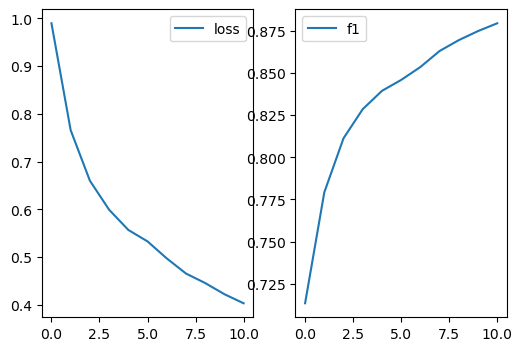

Epoch 12


loss: 0.336, F1: 0.906:   1%|          | 1/89 [00:30<45:01, 30.70s/it]


KeyboardInterrupt: 

In [17]:
for epoch in range(len(train_loss_history_ef4), NUM_EPOCHS):
    print(f"Epoch {epoch}")
    train_loss, train_micro_f1 = train(model_ef4, all_train_loader, criterion_ef4, optimizer_ef4, device)
#     scheduler.step()
    clear_output(True)

    print(f"Train loss: {train_loss:.3f}, Train micro F1: {train_micro_f1:.3f}")
    train_loss_history_ef4.append(train_loss)
    train_micro_f1_history_ef4.append(train_micro_f1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

    ax1.plot(train_loss_history_ef4[1:], label='loss')
    ax1.legend()
    ax2.plot(train_micro_f1_history_ef4[1:], label='f1')
    ax2.legend()
    
    plt.show()
    torch.save(model_ef4.state_dict(), f'model_ef2_v2_m_3l_{epoch}.pth')

    if train_micro_f1 > 0.8 + add or train_micro_f1 > 0.88:
        submission_ef4 = pd.read_csv(PATH_TO_TEST_CSV)
        submission_ef4 = submission_ef4.set_index('image_id')
        submission_ef4['label'] = -1
        
        model_ef4.eval()

        for image, pathes in tqdm(test_loader):
            image = image.to(device)
            # Вычисление предсказания
            with torch.no_grad():
                prediction = model_ef4(image)
            labels = torch.argmax(prediction, dim=1)
            for i, path in enumerate(pathes):
                submission_ef4.loc[path, 'label'] = id2label[labels[i].item()]
        submission_ef4 = submission_ef4.reset_index()
        assert (submission_ef4.label == -1).sum() == 0

        submission_ef4.to_csv(f'submission_ef2_v2_m_3l_li-zan-men_{epoch}.csv', index=False)
        add += 0.03

In [19]:
torch.save(model_ef4.state_dict(), 'model_ef2_v2_m_3l_last.pth')


In [ ]:
torch.feqfeq.save(model_ef4.state_dict(), 'model_with_Adam_15.pth')


In [ ]:
torch.load('model.pth')

In [ ]:
model.load_state_dict(model_state_dict)
